# Brownian Bridge

In [184]:
#dataframe datos de compositores 

datos_composers = {}
carpeta = r'Sequences\labels'
archivos_en_carpeta = os.listdir(carpeta)
print(archivos_en_carpeta)
index0 = 0
indice = 0

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa, header = None)
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    datos_composers[composer] = {} #genero bibio para composer
    datos_composers[composer]['Birth_year'] = archivo.split('-')[0] #año de nacimiento
    index1 = serie.iloc[0, 0].split('\t')[0] #el # del primer serie del composer
    index2 = int(serie.iloc[len(serie)-3, 0].split('\t')[0]) - index0 # # Piezas
    index0 = index2 + index0 # numero total de piezas anteriores
    datos_composers[composer]['# Piezas'] = index2 # Piezas
    datos_composers[composer]['Indice'] = indice
    indice += 1

datos_composers_df = pd.DataFrame(datos_composers)
print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])
print(datos_composers_df)    

composers = {}
M = 0
carpeta = r'Sequences\Series'
archivos_en_carpeta = os.listdir(carpeta)

for archivo in archivos_en_carpeta:
    ruta_completa = os.path.join(carpeta, archivo)
    serie = pd.read_csv(ruta_completa)
    # escoge una serie
    composer = archivo.split('-')[1].capitalize() # nombre compositor
    composers[composer] = {}

    for pieza in range( datos_composers[composer]['# Piezas'] ):
        N = serie.iloc[0, 0].split('\t')[1] # # de elementos por pieza
        M = int(N) + M
        index_n1 = 0 
        index_n2 = int(N)+2 
        serie_n = serie[index_n1 + 2:index_n2].reset_index(drop=True) # resetear index
        serie = serie[index_n2 +1:] # recortar serie Original
        serie_n.index += 1 # que index empiece desde 1
        num_serie_T = serie.columns[0]  # numero de serie de todo el dataset
        num_serie = pieza + 1
        composers[composer]['Serie_'+str(num_serie)] = serie_n.squeeze().to_numpy().astype(float) # agregamos pieza al dicc composer con key como # serie
print('Número total de elementos de todo el dataset: ', M)

['1397-dufay-Labels.txt', '1500-morales-Labels.txt', '1521-desprez-Labels.txt', '1525-palestrina-Labels.txt', '1532-lasso-Labels.txt', '1538-byrd-Labels.txt', '1548-victoria-Labels.txt', '1557-gabrielis-Labels.txt', '1563-dowland-Labels.txt', '1566-gesualdo-Labels.txt', '1567-monteverdi-Labels.txt', '1583-frescobaldi-Labels.txt', '1587-scheidt-Labels.txt', '1616-froberger-Labels.txt', '1629-anglebert-Labels.txt', '1632-lully-Labels.txt', '1637-buxtehude-Labels.txt', '1653-pachelbel-Labels.txt', '1668-couperin-Labels.txt', '1671-albinoni-Labels.txt', '1678-vivaldi-Labels.txt', '1681-telemann-Labels.txt', '1682-dandrieu-Labels.txt', '1683-rameau-Labels.txt', '1685-handel-Labels.txt', '1685-scarlatti-Labels.txt', '1688-zipoli-Labels.txt', '1721-bach-js-Labels.txt', '1732-haydn-Labels.txt', '1736-albrechtsberger-Labels.txt', '1752-clementi-Labels.txt', '1756-mozart-Labels.txt', '1770-beethoven-Labels.txt', '1771-cramer-Labels.txt', '1782-paganini-Labels.txt', '1797-schubert-Labels.txt', '1

C:\Users\PC BULLOCK\AppData\Local\Temp\ipykernel_3944\2143628794.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total Pieces = ',datos_composers_df.sum(axis=1)[1])


Total Pieces =  10061
           Dufay Morales Desprez Palestrina Lasso  Byrd Victoria Gabrielis  \
Birth_year  1397    1500    1521       1525  1532  1538     1548      1557   
# Piezas      13      88      35         61    70   109      326        23   
Indice         0       1       2          3     4     5        6         7   

           Dowland Gesualdo  ...  Karg Respighi Medtner Bartok Stravinsky  \
Birth_year    1563     1566  ...  1877     1879    1880   1881       1882   
# Piezas        61       37  ...    12       12       7     17         37   
Indice           8        9  ...    67       68      69     70         71   

           Prokofiev Hindemith Gerswhin Shostakovich Messiaen  
Birth_year      1891      1895     1898         1906     1908  
# Piezas           6        20       12          109        9  
Indice            72        73       74           75       76  

[3 rows x 77 columns]
Número total de elementos de todo el dataset:  8250485


Método de interpolación entre dos puntos mediante un proceso estocástico, manteniendo las propiedades de un movimiento browniano (o proceso de Wiener).

$X(T)=X(0)+\dfrac{t}{T}\left( X(T)-X(0) \right)+W(t)-\dfrac{t}{T}W(T)$

Donde:  
- $W(t)$ = Proceso de Wiener
- $t$ = Tiempo actual (inicial)
- $T$ = Tiempo final
- $X(0)$ = Valor inicial
- $X(T)$ = Valor final

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import PchipInterpolator

In [3]:
def brownian_bridge(t0, tT, x0, xT, n_steps=100):
    t = np.linspace(t0, tT, n_steps)
    #Generar movimiento browniano con media cero
    W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
    W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y suma acumulativa
    # Interpolación del Brownian Bridge
    X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
    return t, X

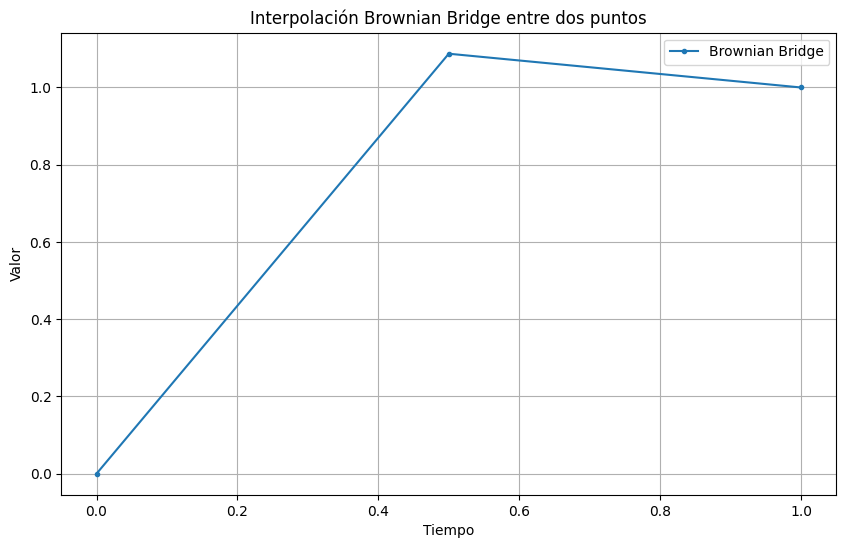

In [5]:
# Parámetros del Brownian Bridge
t0 = 0      # Tiempo inicial
tT = 1      # Tiempo final
x0 = 0      # Valor en t0
xT = 1      # Valor en tT
n_steps = 3  # Número de pasos en la interpolación

# Generar interpolación usando Brownian Bridge
t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
# t, X = interpolador_hermite(np.array([1,5,2,6]), 10)

# Graficar el resultado
plt.figure(figsize=(10, 6))
plt.plot(t, X,".-", label='Brownian Bridge')
# plt.scatter([1,2,3,4,5],np.array([1,3,2,7,5]), color='red', zorder=5, label='Puntos inicial y final')
plt.title('Interpolación Brownian Bridge entre dos puntos')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def arm_detector(y,window_size):
    window_size = window_size
    threshold_high = 2.3
    threshold_low = -2.3

    transition_point = None

    # Desplazar la ventana a lo largo del array
    for i in range(len(y) - window_size):
        window = y[i:i + window_size]
        
        # Verificar si hay valores por arriba de 2.5 o por abajo de -2.5
        if not np.any(window >= threshold_high) and not np.any(window <= threshold_low):
            transition_point = i
            break
        else:
            continue 

    return transition_point

def J_univariante(X,tau, corte):
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2)-np.array(p1))
    x1 = X[tau:]
    y1 = X[:-tau]
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))
    if corte:
        transition_point1 = arm_detector(ff1, 500)
        transition_point2 = arm_detector(ff2, 500)
        print(len(ff1),len(ff2))
        if transition_point2 is not None:
            ff2 = ff2[:transition_point2]
        elif transition_point2 is None:
            transition_point2 = len(ff2)
        if transition_point1 is not None and transition_point1 < transition_point2:
            ff1 = ff1[:transition_point1]
        else:
            ff1 = ff1[:transition_point2]
        print(transition_point1, transition_point2)

    vectores = []
    for i in range(len(ff1)-1):
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i+1], ff2[i+1]]
        cuadrante = [[p2[0]-p1[0], p2[1]-p1[1]], [p2[0]-p1[0], p2[1]+2*np.pi-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]],[p2[0]+2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]+2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-p1[0],p2[1]-2*np.pi-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]-2*np.pi-p1[1]],[p2[0]-2*np.pi-p1[0],p2[1]-p1[1]],
            [p2[0]-2*np.pi-p1[0],p2[1]+2*np.pi-p1[1]]]
        distancia1 = [distancia(p1,c) for c in cuadrante]
        p2 = cuadrante[np.argmin(distancia1)]
        vectores.append([p2[0]-p1[0],p2[1]-p1[1]])
    angulos = []
    for i in range(len(vectores)-1):
        v1=vectores[i]
        v2=vectores[i+1]
        v1_norm=v1/np.linalg.norm(v1)
        v2_norm=v2/np.linalg.norm(v2)
        angulo=np.arccos(np.clip(np.dot(v1_norm,v2_norm),-1.0,1.0))
        cruz=v1[0]*v2[1]-v1[1]*v2[0]
        if cruz>0:
            angulo=np.pi-angulo
        if cruz==0 and angulo==0:
            angulo=angulo
        if cruz==0 and angulo<0:
            angulo=np.pi
        if cruz<0:
            angulo=angulo+np.pi
        angulos.append(angulo)
    e=[]
    for k in range(len(angulos)):
        e.append(np.exp(angulos[k]*1j))
    e1=np.sum(e)/len(angulos)
    J=1.-np.abs(e1.real)
    return J

# Aplicación a series de Rössler

In [15]:
orbit_values = []
x = 0.6
r = 3.4

def logistic_map(r, x):
    return r * x * (1 - x)

for _ in range(1000): # Converger
    x = logistic_map(r, x)


for _ in range(2000):
    x = logistic_map(r, x)
    orbit_values.append(x)
orbit_values = np.array(orbit_values)



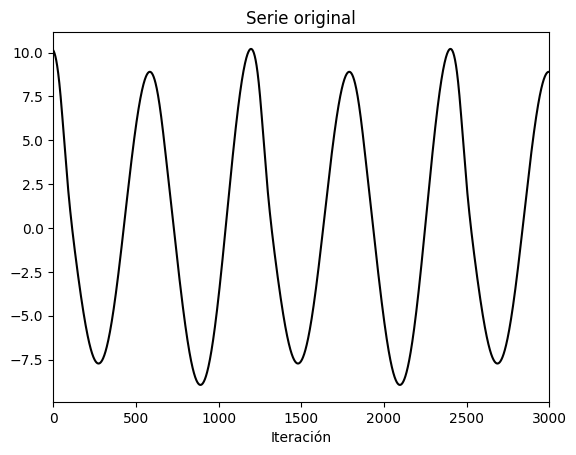

J = 0.0034420784920827785


In [383]:
s_0 = np.loadtxt("x_6.0.txt")
# s_0 = orbit_values
# s_0 = np.loadtxt("lorenz_x_28.0.txt")

plt.title("Serie original")
plt.plot(s_0,"k")
plt.xlim(0,3000)
plt.xlabel('Iteración')
plt.show()

print("J =",J_univariante(s_0,1, False))

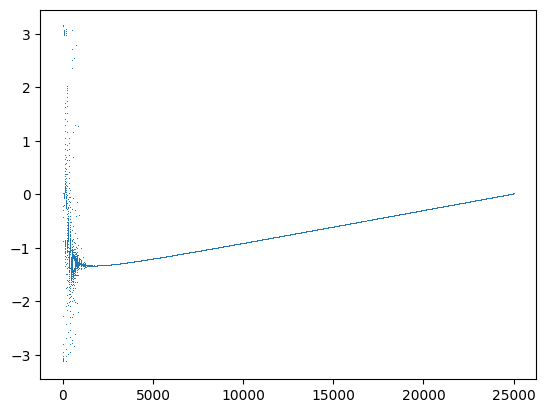

In [384]:
plt.plot(np.angle(np.fft.rfft(s_0)),",")
# plt.xlim(0,1000)
plt.show()

## Discretización de los datos

In [160]:
def discretizar(array, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    window = (np.abs(np.min(array)) + np.abs(np.max(array)))/(num_partitions - 1)
    discretizador = [np.min(array)+window*(i) for i in range(num_partitions)]
    if discretizador[len(discretizador)-1] != np.max(array):
        discretizador[len(discretizador)-1] = np.max(array)
    array_discreto = []
    for i,valor in enumerate(array):
        array_discreto.append(min(discretizador, key=lambda x: abs(x - valor)))

    return array_discreto

In [85]:
def discretizar_x(array_y, num_partitions):
    if num_partitions == 1:
        print(" Minimo de particiones: 2")
        return np.array([])
    array_x = range(int(len(array_y)))
    window = (len(array_x))/(num_partitions - 1)
    x_discreto = [int(window*(i)) for i in range(num_partitions)]
    array_discreto = []
    for i in x_discreto[0:len(x_discreto)-1]:
        array_discreto.append(array_y[i])
    array_discreto.append(array_y[len(array_x)-1])

    return x_discreto, array_discreto

In [343]:
import numpy as np

def encontrar_extremos_locales(data):
    """
    Encuentra los mínimos y máximos locales de un array de datos.
    
    Parameters:
    data (array): Secuencia de datos cuasi-periódica o n-periódica.
    
    Returns:
    extremos_locales (array): Array que contiene los mínimos y máximos locales.
    """
    # Derivada discreta (diferencias finitas)
    derivada = np.diff(data)
    
    # Buscamos cambios de signo en la derivada (esto indica un máximo o un mínimo)
    maxima = np.where((derivada[:-1] > 0) & (derivada[1:] < 0))[0] + 1
    minima = np.where((derivada[:-1] < 0) & (derivada[1:] > 0))[0] + 1
    
    # Unimos los índices de los máximos y mínimos
    indices_extremos = np.sort(np.concatenate((maxima, minima)))
    if 0 not in indices_extremos:
        indices_extremos = np.insert(indices_extremos, 0, 0)
    
    # Extraemos los valores de los máximos y mínimos locales
    extremos_locales = data[indices_extremos]
    
    return indices_extremos, extremos_locales


## Interpolación de los datos discretos

In [ ]:
def interpolador_estocastico(s_0_discreto, n_steps):
    t_list, X_list = [], []
    for i in range(len(s_0_discreto)- 1):
        t0 = i
        tT = i+1
        x0 = s_0_discreto[i]
        xT = s_0_discreto[i+1]
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps)
        t_list = np.concatenate((t_list, t))
        X_list = np.concatenate((X_list, X))
    return t_list, X_list

In [ ]:
def interpolador_hermite(s_0_discreto, n_steps):
    # Generar los puntos de tiempo correspondientes a los puntos discretos
    t_discreto = np.arange(len(s_0_discreto))

    # Crear un interpolador hermitiano (PCHIP) usando los puntos discretos
    interpolador_pchip = PchipInterpolator(t_discreto, s_0_discreto)

    # Crear una lista de tiempo interpolada con mayor resolución
    t_fina = np.linspace(t_discreto[0], t_discreto[-1], n_steps * (len(s_0_discreto) - 1))

    # Interpolar los valores usando el interpolador PCHIP
    X_fina = interpolador_pchip(t_fina)
    
    # Asegurar que los puntos originales estén en los valores interpolados
    t_fina_con_originales = np.union1d(t_fina, t_discreto)
    X_fina_con_originales = interpolador_pchip(t_fina_con_originales)
    
    return t_fina_con_originales, X_fina_con_originales

In [366]:
def interpolador(subject, method, size):
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])
    data = subject
    x = np.arange(len(data))
    x_new = np.linspace(0, len(data) - 1, size)
    x_new = np.unique(np.concatenate((x, x_new)))  
    if method == 'lineal':
        data_interp = np.interp(x_new, x, data)
    if method == 'herm':
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    return data_interp

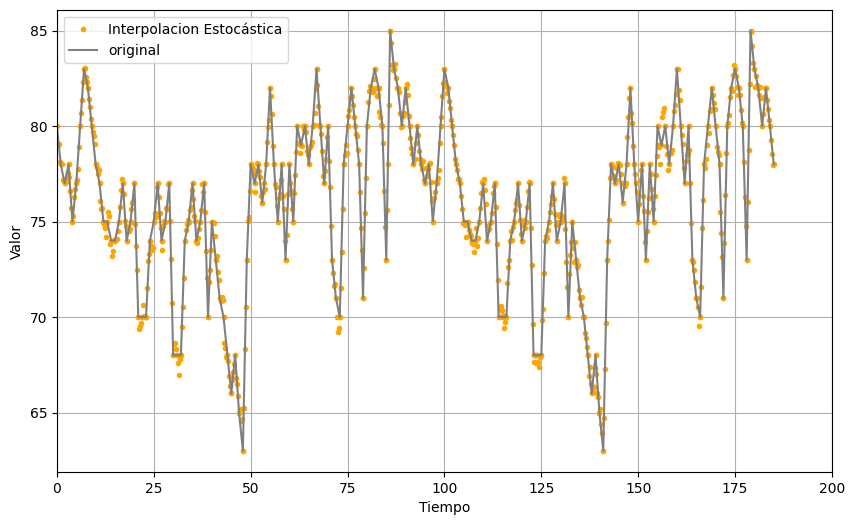

5092 5092
771 620
463 463
None 463
1000 1000
None 1000
93 93
None 93
Hermitiano: 0.6879144109277271, Estocástico: 0.9769503282036722, Discreto: 0.6859858186229258, OG: 0.930478746499246


In [382]:
s_0 = composers['Bach']['Serie_13']
ñosta= np.load('J_interpolacion_hermite_cortado/1721_J_interp_Bach_herm.npy')
# for i in range(len(ñosta)):
#     if ñosta[i] < 0.6:
#         print(i, ñosta[i])
# s_0 = np.loadtxt("x_6.0.txt")
# s_0 = orbit_values
# s_0 = np.loadtxt("lorenz_x_28.0.txt")
# x_discreto, s_0_discreto = discretizar_x(s_0, 350)
# x_discreto, s_0_discreto = encontrar_extremos_locales(s_0)

# Graficar el resultado
t_estocastico, X_estocastico = interpolador_estocastico(s_0, 5)
X_herm = interpolador(s_0,'herm', 10000)


def norm(t_list):
    t_list_norm = (t_list - np.min(t_list)) / (np.max(t_list) - np.min(t_list)) 
    return t_list_norm


plt.figure(figsize=(10, 6))
plt.plot(t_estocastico, X_estocastico,'.', color = 'orange', label = 'Interpolacion Estocástica')
# plt.plot(norm(t_estocastico)*np.max(x_discreto), X_estocastico, color = 'orange', label = 'Interpolacion Estocástica')
# plt.plot(norm(t_herm)*np.max(x_discreto), X_herm,'.-' ,color = 'red', alpha = 0.6, label = 'Interpolacion Hermitiana')
plt.plot(s_0, color='gray', label = 'original')
# plt.plot(t_herm, X_herm,'.', color = 'red',alpha=0.6, label = 'Interpolacion Hermite')
# plt.plot(x_discreto,s_0_discreto,"o", label='Puntos discretos')
# plt.title('Interpolación Brownian Bridge entre dos puntos')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.xlim(0,200)
plt.legend()
plt.grid(True)
plt.show()
print(f'Hermitiano: {J_univariante(X_herm,1, True)}, Estocástico: {J_univariante(X_estocastico,1, True)}, Discreto: {J_univariante(s_0_discreto,1,True)}, OG: {J_univariante(s_0,1,True)}')